In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from domain_adaptation import CNNClassifier
from domain_adaptation.utils import EvalOnDomains
from utils.preprocessing import feature_normalization

plt.style.use('science')

plt.rcParams['mathtext.fontset'] = 'custom' 
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans' 
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic' 
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold' 
plt.rcParams['font.size'] = 16 
plt.rcParams['mathtext.fontset'] = 'stix' 
plt.rcParams['font.family'] = 'STIXGeneral' 

Using TensorFlow backend.


In [2]:
num_cores = multiprocessing.cpu_count()
num_folds = 5
use_gpu = False

if use_gpu:
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
    config = tf.ConfigProto(gpu_options=gpu_options)
    config.gpu_options.allow_growth = True
else:
    config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
                            inter_op_parallelism_threads=num_cores, 
                            allow_soft_placement=True,
                            device_count = {'CPU' : 1,
                                            'GPU' : 0}
                        )

session = tf.Session(config=config)
tf.keras.backend.set_session(session)

## Source-Only

In [3]:
crossval_index = np.load('./data/crossval_index.npy')
data_mat = np.load('./data/cstr_rawdata.npy')
X = data_mat[:, :-4]
y = data_mat[:, -4]
d = data_mat[:, -3]
X = X[np.where(d == 0)[0]]
y = y[np.where(d == 0)[0]]

In [4]:
Xtr, Xts, ytr, yts = train_test_split(X, y, train_size=0.8, stratify=y)

Xtr = feature_normalization(Xtr)[..., np.newaxis]
ytr = tf.keras.utils.to_categorical(ytr)

Xts = feature_normalization(Xts)[..., np.newaxis]
yts = tf.keras.utils.to_categorical(yts)

print(Xtr.shape, ytr.shape, Xts.shape, yts.shape)

(1040, 1400, 1) (1040, 13) (260, 1400, 1) (260, 13)


In [5]:
cnn = CNNClassifier(input_shape=(1400, 1), n_classes=13)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
hist_dict = cnn.fit(Xtr, ytr, batch_size=256, epochs=100, validation_data=(Xts, yts))

Train on 1040 samples, validate on 260 samples
Epoch 1/100
1040/1040 [==============================] - 15s 14ms/sample - loss: 1.5682 - acc: 0.5712 - val_loss: 0.3654 - val_acc: 0.8538
Epoch 2/100
 768/1040 [=====================>........] - ETA: 1s - loss: 0.2384 - acc: 0.9219

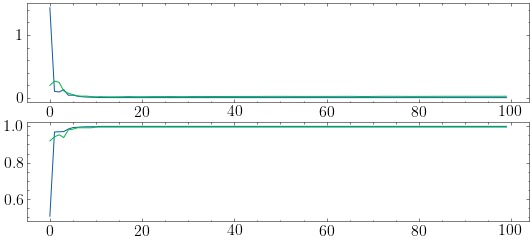

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(9, 4))

axes[0].plot(hist_dict.history['loss'])
axes[0].plot(hist_dict.history['val_loss'])

axes[1].plot(hist_dict.history['acc'])
axes[1].plot(hist_dict.history['val_acc'])

NameError: name 'cmat' is not defined

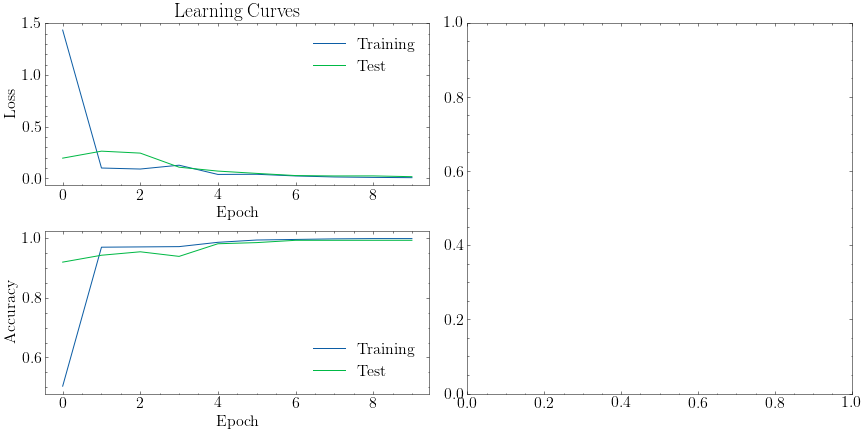

In [8]:
fig3 = plt.figure(constrained_layout=True, figsize=(12, 6))

gs = fig3.add_gridspec(2, 2)
ax = fig3.add_subplot(gs[0, 0])
ax.plot(hist_dict.history['loss'][:10], label='Training')
ax.plot(hist_dict.history['val_loss'][:10], label='Test')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Learning Curves')
ax.legend()
ax = fig3.add_subplot(gs[1, 0])
ax.plot(hist_dict.history['acc'][:10], label='Training')
ax.plot(hist_dict.history['val_acc'][:10], label="Test")
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
ax = fig3.add_subplot(gs[:, 1:])

norm = mpl.colors.Normalize(vmin=0, vmax=20)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap='binary')
cmap.set_array([])

ax.imshow(cmat, aspect='auto', cmap='binary')
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax.set_xticklabels([r"$F_{" + str(int(i)) + "}$" for i in range(12)] + ["N"])
ax.set_yticklabels([r"$F_{" + str(int(i)) + "}$" for i in range(12)] + ["N"])
ax.set_ylabel('Ground-Truth')
ax.set_xlabel('Predictions')
plt.tight_layout()

cbar =  fig.colorbar(cmap, ax=ax)
cbar.set_ticks([2 * i for i in range(11)])
plt.savefig('./Figures/Presentation/Cmat_CNN.pdf')

In [ ]:
cmat = confusion_matrix(yts.argmax(axis=1), yp)

norm = mpl.colors.Normalize(vmin=0, vmax=20)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap='binary')
cmap.set_array([])

fig, ax = plt.subplots(1, 1, figsize=(7, 6))
ax.imshow(cmat, aspect='auto', cmap='binary')
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax.set_xticklabels([r"$F_{" + str(int(i)) + "}$" for i in range(12)] + ["N"])
ax.set_yticklabels([r"$F_{" + str(int(i)) + "}$" for i in range(12)] + ["N"])
ax.set_ylabel('Ground-Truth')
ax.set_xlabel('Predictions')

cbar =  fig.colorbar(cmap, ax=ax)
cbar.set_ticks([2 * i for i in range(11)])

plt.savefig('./Figures/Ch6/CMat_CNN.pdf')

## Domain Adaptation Experiments

In [3]:
df = pd.read_csv('./data/cstr_rawdata.csv')
crossval_index = np.load('./data/crossval_index.npy')

data_mat = df.values
X = data_mat[:, :-4]
y = data_mat[:, -4]
d = data_mat[:, -3]

Xtr = feature_normalization(X[np.where(d == 0)[0], :, np.newaxis])
ytr = tf.keras.utils.to_categorical(y[np.where(d == 0)[0]])

Xtargets = [feature_normalization(X[np.where(d == domain)[0], :, np.newaxis]) for domain in range(1, 7)]
ytargets = [y[np.where(d == domain)[0]] for domain in range(1, 7)]

In [4]:
cnn = CNNClassifier(input_shape=(1400, 1), n_classes=13)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [5]:
cnn.model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1400, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1400, 32)          192       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 700, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 700, 64)           12352     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 350, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 350, 128)          49280     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 175, 128)          0     

In [6]:
cback = EvalOnDomains(model=cnn.model, Xtargets=Xtargets, ytargets=ytargets)
hist_dict = cnn.fit(Xtr, ytr, batch_size=256, epochs=100, callbacks=[cback])

Train on 1300 samples
Epoch 1/100
1280/1300 [============================>.] - ETA: 0s - loss: 1.3652 - acc: 0.5203Domain: 0, Acc: 0.7884615384615384
Domain: 1, Acc: 0.7346153846153847
Domain: 2, Acc: 0.7653846153846153
Domain: 3, Acc: 0.6730769230769231
Domain: 4, Acc: 0.5692307692307692
Domain: 5, Acc: 0.5230769230769231
1300/1300 [==============================] - 7s 6ms/sample - loss: 1.3485 - acc: 0.5269
Epoch 2/100
1280/1300 [============================>.] - ETA: 0s - loss: 0.1217 - acc: 0.9711Domain: 0, Acc: 0.85
Domain: 1, Acc: 0.7576923076923077
Domain: 2, Acc: 0.7346153846153847
Domain: 3, Acc: 0.7153846153846154
Domain: 4, Acc: 0.5692307692307692
Domain: 5, Acc: 0.46153846153846156
1300/1300 [==============================] - 6s 5ms/sample - loss: 0.1229 - acc: 0.9708
Epoch 3/100
1280/1300 [============================>.] - ETA: 0s - loss: 0.0649 - acc: 0.9734Domain: 0, Acc: 0.8423076923076923
Domain: 1, Acc: 0.8
Domain: 2, Acc: 0.7846153846153846
Domain: 3, Acc: 0.68076923

Epoch 22/100
1280/1300 [============================>.] - ETA: 0s - loss: 4.8967e-05 - acc: 1.0000Domain: 0, Acc: 0.8115384615384615
Domain: 1, Acc: 0.7115384615384616
Domain: 2, Acc: 0.7269230769230769
Domain: 3, Acc: 0.6076923076923076
Domain: 4, Acc: 0.7423076923076923
Domain: 5, Acc: 0.55
1300/1300 [==============================] - 6s 5ms/sample - loss: 4.8319e-05 - acc: 1.0000
Epoch 23/100
1280/1300 [============================>.] - ETA: 0s - loss: 4.3452e-05 - acc: 1.0000Domain: 0, Acc: 0.8115384615384615
Domain: 1, Acc: 0.7115384615384616
Domain: 2, Acc: 0.7346153846153847
Domain: 3, Acc: 0.6076923076923076
Domain: 4, Acc: 0.7423076923076923
Domain: 5, Acc: 0.55
1300/1300 [==============================] - 6s 5ms/sample - loss: 4.3471e-05 - acc: 1.0000
Epoch 24/100
1280/1300 [============================>.] - ETA: 0s - loss: 3.9793e-05 - acc: 1.0000Domain: 0, Acc: 0.8076923076923077
Domain: 1, Acc: 0.7115384615384616
Domain: 2, Acc: 0.7346153846153847
Domain: 3, Acc: 0.6115384

Domain: 5, Acc: 0.5
1300/1300 [==============================] - 8s 6ms/sample - loss: 1.6274e-05 - acc: 1.0000
Epoch 43/100
1280/1300 [============================>.] - ETA: 0s - loss: 1.6264e-05 - acc: 1.0000Domain: 0, Acc: 0.8076923076923077
Domain: 1, Acc: 0.7038461538461539
Domain: 2, Acc: 0.7269230769230769
Domain: 3, Acc: 0.6076923076923076
Domain: 4, Acc: 0.7230769230769231
Domain: 5, Acc: 0.5
1300/1300 [==============================] - 7s 5ms/sample - loss: 1.6035e-05 - acc: 1.0000
Epoch 44/100
1280/1300 [============================>.] - ETA: 0s - loss: 1.5125e-05 - acc: 1.0000Domain: 0, Acc: 0.8076923076923077
Domain: 1, Acc: 0.7038461538461539
Domain: 2, Acc: 0.7269230769230769
Domain: 3, Acc: 0.6076923076923076
Domain: 4, Acc: 0.7230769230769231
Domain: 5, Acc: 0.5
1300/1300 [==============================] - 6s 5ms/sample - loss: 1.5479e-05 - acc: 1.0000
Epoch 45/100
1280/1300 [============================>.] - ETA: 0s - loss: 1.4980e-05 - acc: 1.0000Domain: 0, Acc: 0.80

Epoch 64/100
1280/1300 [============================>.] - ETA: 0s - loss: 8.6254e-06 - acc: 1.0000Domain: 0, Acc: 0.8
Domain: 1, Acc: 0.6961538461538461
Domain: 2, Acc: 0.7269230769230769
Domain: 3, Acc: 0.6076923076923076
Domain: 4, Acc: 0.7153846153846154
Domain: 5, Acc: 0.4807692307692308
1300/1300 [==============================] - 7s 5ms/sample - loss: 8.8270e-06 - acc: 1.0000
Epoch 65/100
1280/1300 [============================>.] - ETA: 0s - loss: 8.7446e-06 - acc: 1.0000Domain: 0, Acc: 0.8
Domain: 1, Acc: 0.6961538461538461
Domain: 2, Acc: 0.7269230769230769
Domain: 3, Acc: 0.6076923076923076
Domain: 4, Acc: 0.7153846153846154
Domain: 5, Acc: 0.47692307692307695
1300/1300 [==============================] - 7s 5ms/sample - loss: 8.6246e-06 - acc: 1.0000
Epoch 66/100
1280/1300 [============================>.] - ETA: 0s - loss: 7.7680e-06 - acc: 1.0000Domain: 0, Acc: 0.7923076923076923
Domain: 1, Acc: 0.6961538461538461
Domain: 2, Acc: 0.7230769230769231
Domain: 3, Acc: 0.60769230

Domain: 4, Acc: 0.7076923076923077
Domain: 5, Acc: 0.47307692307692306
1300/1300 [==============================] - 7s 6ms/sample - loss: 5.9895e-06 - acc: 1.0000
Epoch 85/100
1280/1300 [============================>.] - ETA: 0s - loss: 5.9638e-06 - acc: 1.0000Domain: 0, Acc: 0.7884615384615384
Domain: 1, Acc: 0.6923076923076923
Domain: 2, Acc: 0.7192307692307692
Domain: 3, Acc: 0.6076923076923076
Domain: 4, Acc: 0.7076923076923077
Domain: 5, Acc: 0.47307692307692306
1300/1300 [==============================] - 8s 6ms/sample - loss: 5.8979e-06 - acc: 1.0000
Epoch 86/100
1280/1300 [============================>.] - ETA: 0s - loss: 5.8361e-06 - acc: 1.0000Domain: 0, Acc: 0.7884615384615384
Domain: 1, Acc: 0.6923076923076923
Domain: 2, Acc: 0.7192307692307692
Domain: 3, Acc: 0.6076923076923076
Domain: 4, Acc: 0.7076923076923077
Domain: 5, Acc: 0.46923076923076923
1300/1300 [==============================] - 7s 5ms/sample - loss: 5.8058e-06 - acc: 1.0000
Epoch 87/100
1280/1300 [===========

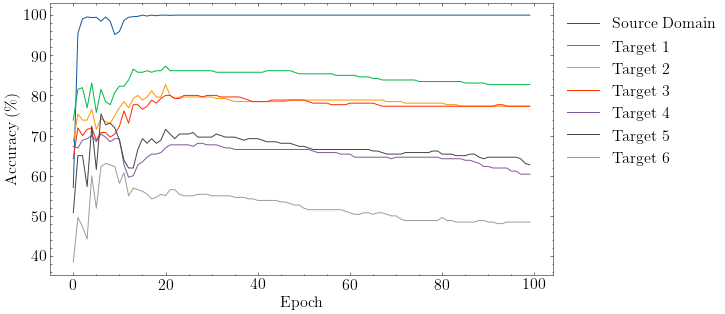

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
ax.plot(100 * np.array(hist_dict.history['acc']), label='Source Domain')
ax.plot(100 * np.array(hist_dict.history['dom0_acc']), label='Target 1')
ax.plot(100 * np.array(hist_dict.history['dom1_acc']), label='Target 2')
ax.plot(100 * np.array(hist_dict.history['dom2_acc']), label='Target 3')
ax.plot(100 * np.array(hist_dict.history['dom3_acc']), label='Target 4')
ax.plot(100 * np.array(hist_dict.history['dom4_acc']), label='Target 5')
ax.plot(100 * np.array(hist_dict.history['dom5_acc']), label='Target 6')
ax.set_ylabel('Accuracy (\%)')
ax.set_xlabel('Epoch')
ax.legend(bbox_to_anchor=(1, 1))
plt.savefig('./Figures/Ch6/CNN_Training.pdf')

In [7]:
cmats = []
for Xt, yt in zip(Xtargets, ytargets):
    yp = cnn.predict(Xt)
    cmat = confusion_matrix(yt, yp)
    cmats.append(cmat)

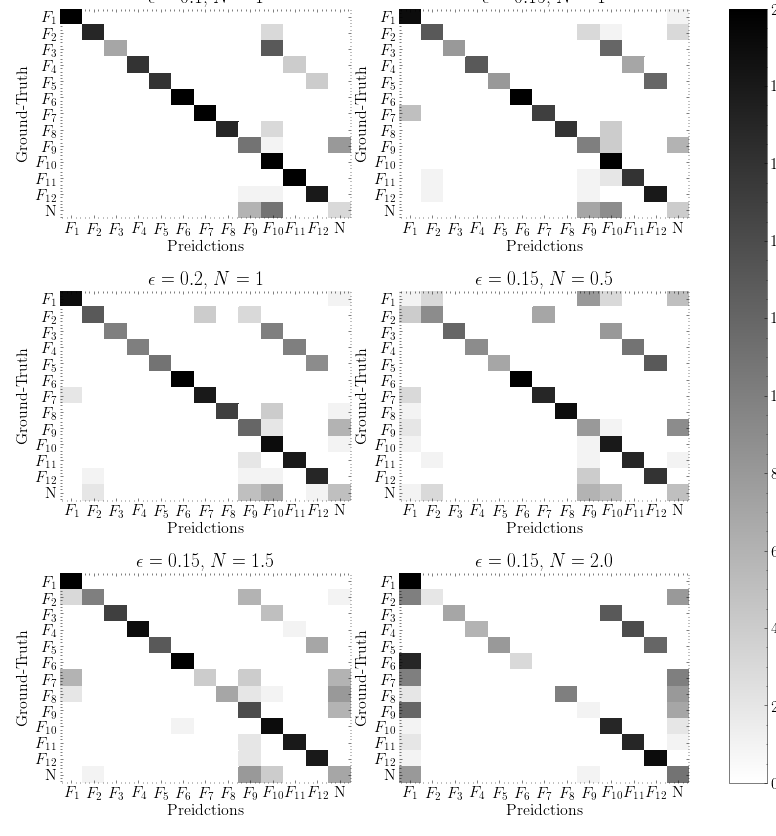

In [8]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
eps = [0.1, 0.15, 0.2, 0.15, 0.15, 0.15]
Ns = [1, 1, 1, 0.5, 1.5, 2.0]
for cmat, ax, ei, Ni in zip(cmats, axes.flatten(), eps, Ns):
    sns.heatmap(cmat, annot=False, ax=ax, cmap='binary', cbar=False,
                xticklabels=[r"$F_{" + str(int(i)) + "}$" for i in range(1, 13)] + ["N"],
                yticklabels=[r"$F_{" + str(int(i)) + "}$" for i in range(1, 13)] + ["N"])
    ax.set_title(r'$\epsilon = {}$, $N = {}$'.format(ei, Ni))
    ax.set_ylabel('Ground-Truth')
    ax.set_xlabel('Preidctions')
plt.tight_layout()

norm = mpl.colors.Normalize(vmin=0, vmax=20)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap='binary')
cmap.set_array([])
cbar =  fig.colorbar(cmap, ax=axes.ravel().tolist())
cbar.set_ticks([2 * i for i in range(11)])
plt.savefig('./Figures/Ch6/CNNFeatures_Errs.pdf')

In [23]:
n = 1
sum(np.diag(cmats[n])) / sum(sum(cmats[n]))

0.7730769230769231